<a href="https://colab.research.google.com/github/PijushBhuyan/DRU-Net-Skin-Lesion-Segmentation/blob/main/Skin_Lesion_DRU_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r "Training Ground Truth"
!rm -r "Training Input"
!rm -r "Validation Ground Truth"
!rm -r "Validation Input"
# !rm -r "Test Input"

rm: cannot remove 'Training Ground Truth': No such file or directory
rm: cannot remove 'Training Input': No such file or directory
rm: cannot remove 'Validation Ground Truth': No such file or directory
rm: cannot remove 'Validation Input': No such file or directory


In [ ]:
#download dataset
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip 
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Test_Input.zip 
!unzip "ISIC2018_Task1-2_Training_Input.zip" &> /dev/null
!unzip "ISIC2018_Task1_Training_GroundTruth.zip" &> /dev/null
!unzip "ISIC2018_Task1-2_Validation_Input.zip" &> /dev/null
!unzip "ISIC2018_Task1_Validation_GroundTruth.zip" &> /dev/null
# !unzip "ISIC2018_Task1-2_Test_Input.zip" &> /dev/null
!rm "ISIC2018_Task1-2_Training_Input.zip"
!rm "ISIC2018_Task1_Training_GroundTruth.zip"
!rm "ISIC2018_Task1-2_Validation_Input.zip"
!rm "ISIC2018_Task1_Validation_GroundTruth.zip"
# !rm "ISIC2018_Task1-2_Test_Input.zip"
!mv "ISIC2018_Task1-2_Training_Input" "Train Input"
!mv "ISIC2018_Task1_Training_GroundTruth" "Train Ground Truth"
!mv "ISIC2018_Task1-2_Validation_Input" "Validation Input"
!mv "ISIC2018_Task1_Validation_GroundTruth" "Validation Ground Truth"
# !mv "ISIC2018_Task1-2_Test_Input" "Test Input"

--2021-12-15 10:14:58--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.147.43
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.147.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11165358566 (10G) [application/zip]
Saving to: ‘ISIC2018_Task1-2_Training_Input.zip’

ISIC2018_Task1-2_Tr 100%[===================>]  10.40G  16.4MB/s    in 11m 15s 

2021-12-15 10:26:14 (15.8 MB/s) - ‘ISIC2018_Task1-2_Training_Input.zip’ saved [11165358566/11165358566]

--2021-12-15 10:26:14--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.92.244
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.92.244|:443... connec

In [ ]:
import os
import glob as glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

IMG_HEIGHT = 128
IMG_WIDTH  = 128
IMG_CHANNELS = 3

In [ ]:
# load dataset file paths
train_path = sorted(glob.glob('./Train Input/*.jpg'))
train_ground_truth_path = sorted(glob.glob('./Train Ground Truth/*_segmentation.png'))
valid_path = sorted(glob.glob('./Validation Input/*.jpg'))
valid_ground_truth_path = sorted(glob.glob('./Validation Ground Truth/*_segmentation.png'))
# test_path = sorted(glob.glob('./Test Input/*.jpg'))

In [ ]:
#build dataset
def buildDataset(input_path,input_channels,output_path,output_channels):
    input_data = np.zeros((len(input_path),IMG_HEIGHT,IMG_WIDTH,input_channels),dtype='float32')
    output_data = np.zeros((len(input_path),IMG_HEIGHT,IMG_WIDTH,output_channels),dtype='bool')
    for i in range(len(input_path)):
        image = cv.imread(input_path[i], cv.COLOR_BGR2RGB)
        image = cv.resize(image,(IMG_HEIGHT,IMG_WIDTH),interpolation=cv.INTER_AREA)
        image = np.array(image)
        image = image.astype('float32')
        image = image/255
        input_data[i] = image
    for i in range(len(output_path)):
        image = cv.imread(output_path[i], cv.COLOR_BGR2RGB)
        image = cv.resize(image,(IMG_HEIGHT,IMG_WIDTH),interpolation=cv.INTER_AREA)
        image = np.array(image)
        image = image.astype('bool')
        image = np.expand_dims(image,axis=-1)
        output_data[i] = image
    return input_data,output_data

In [ ]:
train_data, train_label = buildDataset(train_path,3,train_ground_truth_path,1)
valid_data, valid_label = buildDataset(valid_path,3,valid_ground_truth_path,1)
# test_data, temp = buildDataset(test_path,3,valid_ground_truth_path,1)

In [ ]:
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)
# print(test_data.shape)

(2594, 128, 128, 3)
(2594, 128, 128, 1)
(100, 128, 128, 3)
(100, 128, 128, 1)


#DRU NET


In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# build encoders
#encoder 1
e11 = tf.keras.layers.Conv2D(8, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
e12 = tf.keras.layers.Conv2D(8, (3, 3), kernel_initializer='he_normal', padding='same')(e11)
e12 = tf.keras.layers.BatchNormalization()(e12)
e12_1 = tf.keras.layers.Activation('relu')(e12)
copy1 = tf.keras.layers.Conv2D(8, (3, 3), kernel_initializer='he_normal', padding='same')(e12_1)
copy1 = tf.keras.layers.BatchNormalization()(copy1)
e13 = tf.keras.layers.add([e11,e12,copy1])
e13 = tf.keras.layers.Activation('relu')(e13)
concat1 = tf.keras.layers.concatenate([e11,e13])

#encoder 2
e21 = tf.keras.layers.MaxPooling2D((2, 2))(concat1)
e22 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(e21)
e22 = tf.keras.layers.BatchNormalization()(e22)
e22_1 = tf.keras.layers.Activation('relu')(e22)
copy2 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(e22_1)
copy2 = tf.keras.layers.BatchNormalization()(copy2)
e23 = tf.keras.layers.add([e21,e22,copy2])
e23 = tf.keras.layers.Activation('relu')(e23)
concat2 = tf.keras.layers.concatenate([e21,e23])


#encoder 3
e31 = tf.keras.layers.MaxPooling2D((2, 2))(concat2)
e32 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(e31)
e32 = tf.keras.layers.BatchNormalization()(e32)
e32_1 = tf.keras.layers.Activation('relu')(e32)
copy3 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(e32_1)
copy3 = tf.keras.layers.BatchNormalization()(copy3)
e33 = tf.keras.layers.add([e31,e32,copy3])
e33 = tf.keras.layers.Activation('relu')(e33)
concat3 = tf.keras.layers.concatenate([e31,e33])


#encoder 4
e41 = tf.keras.layers.MaxPooling2D((2, 2))(concat3)
e42 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(e41)
e42 = tf.keras.layers.BatchNormalization()(e42)
e42_1 = tf.keras.layers.Activation('relu')(e42)
copy4 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(e42_1)
copy4 = tf.keras.layers.BatchNormalization()(copy4)
e43 = tf.keras.layers.add([e41,e42,copy4])
e43 = tf.keras.layers.Activation('relu')(e43)
concat4 = tf.keras.layers.concatenate([e41,e43])


#base
b51 = tf.keras.layers.MaxPooling2D((2, 2))(concat4)
b52 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(b51)
b52 = tf.keras.layers.BatchNormalization()(b52)
b52_1 = tf.keras.layers.Activation('relu')(b52)
b53 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(b52_1)
b53 = tf.keras.layers.BatchNormalization()(b53)
b54 = tf.keras.layers.add([b51,b52,b53])
b53 = tf.keras.layers.Activation('relu')(b53)
concat5 = tf.keras.layers.concatenate([b51,b54])

# build decoders

#decoder 1
d11 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same')(concat5)
d11 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(d11)
d11 = tf.keras.layers.concatenate([copy4,d11])
d11 = tf.keras.layers.BatchNormalization()(d11)
d11_1 = tf.keras.layers.Activation('relu')(d11)
d12 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(d11_1)
d12 = tf.keras.layers.BatchNormalization()(d12)
d13 = tf.keras.layers.Conv2D(64, (1, 1), kernel_initializer='he_normal', padding='same')(concat5)
d13 = tf.keras.layers.BatchNormalization()(d13)
d13 = tf.keras.layers.ZeroPadding2D(padding=4)(d13)
d11 = tf.keras.layers.Conv2D(64, (1, 1), kernel_initializer='he_normal', padding='same')(d11)
sum1 = tf.keras.layers.add([d11,d12,d13])
sum1 = tf.keras.layers.Activation('relu')(sum1)

#decoder 2
d21 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2, 2), padding='same')(sum1)
d21 = tf.keras.layers.Conv2D(32, (3, 3),kernel_initializer='he_normal', padding='same')(d21)
d21 = tf.keras.layers.concatenate([copy3,d21])
d21 = tf.keras.layers.BatchNormalization()(d21)
d21_1 = tf.keras.layers.Activation('relu')(d21)
d22 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(d21_1)
d22 = tf.keras.layers.BatchNormalization()(d22)
d23 = tf.keras.layers.Conv2D(32, (1, 1), kernel_initializer='he_normal', padding='same')(sum1)
d23 = tf.keras.layers.BatchNormalization()(d23)
d23 = tf.keras.layers.ZeroPadding2D(padding=8)(d23)
d21 = tf.keras.layers.Conv2D(32, (1, 1), kernel_initializer='he_normal', padding='same')(d21)
sum2 = tf.keras.layers.add([d21,d22,d23])
sum2 = tf.keras.layers.Activation('relu')(sum2)

#decoder 3
d31 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding='same')(sum2)
d31 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(d31)
d31 = tf.keras.layers.concatenate([copy2,d31])
d31 = tf.keras.layers.BatchNormalization()(d31)
d31_1 = tf.keras.layers.Activation('relu')(d31)
d32 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(d31_1)
d32 = tf.keras.layers.BatchNormalization()(d32)
d33 = tf.keras.layers.Conv2D(16, (1, 1), kernel_initializer='he_normal', padding='same')(sum2)
d33 = tf.keras.layers.BatchNormalization()(d33)
d33 = tf.keras.layers.ZeroPadding2D(padding=16)(d33)
d31 = tf.keras.layers.Conv2D(16, (1, 1), kernel_initializer='he_normal', padding='same')(d31)
sum3 = tf.keras.layers.add([d31,d32,d33])
sum3 = tf.keras.layers.Activation('relu')(sum3)

#decoder 4
d41 = tf.keras.layers.Conv2DTranspose(8, (2,2), strides=(2, 2), padding='same')(sum3)
d41 = tf.keras.layers.Conv2D(8, (3, 3), kernel_initializer='he_normal', padding='same')(d41)
d41 = tf.keras.layers.concatenate([copy1,d41])
d41 = tf.keras.layers.BatchNormalization()(d41)
d41_1 = tf.keras.layers.Activation('relu')(d41)
d42 = tf.keras.layers.Conv2D(8, (3, 3), kernel_initializer='he_normal', padding='same')(d41_1)
d42 = tf.keras.layers.BatchNormalization()(d42)
d43 = tf.keras.layers.Conv2D(8, (1, 1), kernel_initializer='he_normal', padding='same')(sum3)
d43 = tf.keras.layers.BatchNormalization()(d43)
d43 = tf.keras.layers.ZeroPadding2D(padding=32)(d43)
d41 = tf.keras.layers.Conv2D(8, (1, 1), kernel_initializer='he_normal', padding='same')(d41)
sum4 = tf.keras.layers.add([d41,d42,d43])
sum4 = tf.keras.layers.Activation('relu')(sum4)
# d44 = tf.keras.layers.Conv2DTranspose(8, (2,2), strides=(2, 2), padding='same')(sum4)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(sum4)


drunet = tf.keras.Model(inputs=[inputs], outputs=[outputs])
drunet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
drunet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  1184        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 8)  32         ['conv2d_1[0][0]']           

In [ ]:
results = drunet.fit(train_data, train_label, validation_split=0.2, batch_size=25, epochs=10)

Epoch 1/10
83/83 [==============================] - 27s 159ms/step - loss: 0.3179 - accuracy: 0.8800 - val_loss: 0.8232 - val_accuracy: 0.7239
Epoch 2/10
83/83 [==============================] - 12s 144ms/step - loss: 0.1982 - accuracy: 0.9264 - val_loss: 0.3272 - val_accuracy: 0.8729
Epoch 3/10
83/83 [==============================] - 12s 144ms/step - loss: 0.1700 - accuracy: 0.9354 - val_loss: 0.2233 - val_accuracy: 0.9130
Epoch 4/10
83/83 [==============================] - 12s 144ms/step - loss: 0.1615 - accuracy: 0.9372 - val_loss: 0.2318 - val_accuracy: 0.9112
Epoch 5/10
83/83 [==============================] - 12s 144ms/step - loss: 0.1495 - accuracy: 0.9425 - val_loss: 0.2408 - val_accuracy: 0.9114
Epoch 6/10
83/83 [==============================] - 12s 144ms/step - loss: 0.1384 - accuracy: 0.9458 - val_loss: 0.2261 - val_accuracy: 0.9075
Epoch 7/10
83/83 [==============================] - 12s 144ms/step - loss: 0.1406 - accuracy: 0.9448 - val_loss: 0.4134 - val_accuracy: 0.8251

In [ ]:
train_pred = drunet.predict(train_data)
train_pred = (train_pred>0.5).astype('bool')

test_pred = drunet.predict(valid_data)
test_pred = (test_pred>0.5).astype('bool')

m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(train_label,train_pred)
train_miou = m.result().numpy()

m.update_state(valid_label,test_pred)
test_miou = m.result().numpy()
print('training M-IOU : '+str(train_miou))
print('training M-IOU : '+str(test_miou))

training M-IOU : 0.7912924
training M-IOU : 0.7923504


#U NET

In [ ]:
#build segmentation model 
inputs_1 = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#Contraction path
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs_1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs_1 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
unet = tf.keras.Model(inputs=[inputs_1], outputs=[outputs_1])
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 128, 8)  224         ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 8)  0           ['conv2d_28[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 128, 128, 8)  584         ['dropout[0][0]']          

In [ ]:
results_1 = unet.fit(train_data, train_label, validation_split=0.2, batch_size=25, epochs=10)

Epoch 1/10
83/83 [==============================] - 11s 108ms/step - loss: 0.3893 - accuracy: 0.8393 - val_loss: 0.3366 - val_accuracy: 0.8481
Epoch 2/10
83/83 [==============================] - 8s 97ms/step - loss: 0.2478 - accuracy: 0.9101 - val_loss: 0.3289 - val_accuracy: 0.8535
Epoch 3/10
83/83 [==============================] - 8s 97ms/step - loss: 0.2057 - accuracy: 0.9249 - val_loss: 0.3652 - val_accuracy: 0.8706
Epoch 4/10
83/83 [==============================] - 8s 97ms/step - loss: 0.1851 - accuracy: 0.9313 - val_loss: 0.2537 - val_accuracy: 0.9052
Epoch 5/10
83/83 [==============================] - 8s 97ms/step - loss: 0.1676 - accuracy: 0.9358 - val_loss: 0.3017 - val_accuracy: 0.8924
Epoch 6/10
83/83 [==============================] - 8s 97ms/step - loss: 0.1655 - accuracy: 0.9364 - val_loss: 0.3033 - val_accuracy: 0.8935
Epoch 7/10
83/83 [==============================] - 8s 96ms/step - loss: 0.1701 - accuracy: 0.9348 - val_loss: 0.2512 - val_accuracy: 0.9102
Epoch 8/10


In [ ]:
train_pred_1 = unet.predict(train_data)
train_pred_1 = (train_pred_1>0.5).astype('bool')

test_pred_1 = unet.predict(valid_data)
test_pred_1 = (test_pred_1>0.5).astype('bool')

m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(train_label,train_pred_1)
train_miou = m.result().numpy()

m.update_state(valid_label,test_pred_1)
test_miou = m.result().numpy()
print('training M-IOU : '+str(train_miou))
print('training M-IOU : '+str(test_miou))

training M-IOU : 0.7726052
training M-IOU : 0.77239823


#DRU Net vs U Net

Text(0.5, 1.0, 'U Net Label')

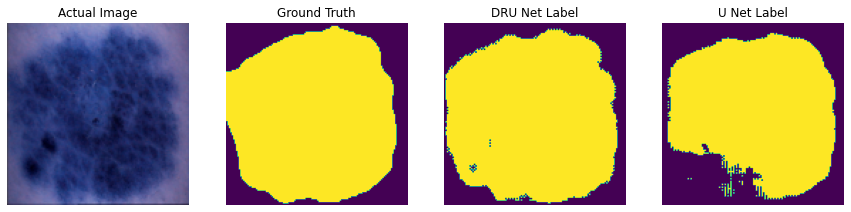

In [ ]:
# Sample Predictions on Test Dataset
import random
i = random.randint(1,100)

fig = plt.figure(figsize=(15,10))

fig.add_subplot(1,4,1)
plt.imshow(valid_data[i])
plt.axis('off')
plt.title('Actual Image')

fig.add_subplot(1,4,2)
plt.imshow(np.squeeze(valid_label[i],axis=-1))
plt.axis('off')
plt.title('Ground Truth')

fig.add_subplot(1,4,3)
plt.imshow(np.squeeze(test_pred[i],axis=-1))
plt.axis('off')
plt.title('DRU Net Label')

fig.add_subplot(1,4,4)
plt.imshow(np.squeeze(test_pred_1[i],axis=-1))
plt.axis('off')
plt.title('U Net Label')